# Installing Packages

In [1]:
# Only install once and then reset runtime
!pip install accelerate
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# Loading Libraries

In [2]:
# Loading Packages
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import optuna
import numpy as np
import random
import accelerate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from transformers import DataCollatorWithPadding



# Importing and Cleaning Data

In [101]:
# Read the data
drive.mount('/content/drive')

bias = pd.read_csv('/content/drive/MyDrive/hackathon/misdirection.csv')

# Selecting out badly formatted columns
clean_bias = bias.loc[:, 'conversation_id':'unique_id']

# Filtering to just accepted vs. rejected
clean_bias = clean_bias[clean_bias['submission_grade'].isin(['accepted', 'rejected'])]

# Removing all NA under user (these do not help)
clean_bias = clean_bias.dropna(subset=['user'])

# Grouping by unique_id and joining each prompt into a single paragraph
grouped = clean_bias.groupby('unique_id')['user'].apply(lambda x: ' '.join(x)).reset_index()

# Selecting the predictor variable to be these paragraphs
X = grouped["user"].astype(str).tolist()

# Creating the predicted variable to be rejected and accepted as binary
y = clean_bias.groupby('unique_id')['submission_grade'].apply(lambda x: x.iloc[-1]).map({'rejected': 'non-violation','accepted': 'violation'}).tolist()

# Split the data in such a way that y is stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-101-8a4262d1d3a2>:5: DtypeWarning: Columns (27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198) have mixed types. Specify dtype option on import or set low_memory=False.
  bias = pd.read_csv('/content/drive/MyDrive/hackathon/misdirection.csv')


# Tokenizing Data

In [102]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Tokenize the data
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=256)

# Creating a customdataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label = 0 if self.labels[idx] == 'non-violation' else 1
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset objects
train_dataset = CustomDataset(train_encodings, [0 if label == 'non-violation' else 1 for label in y_train])
test_dataset = CustomDataset(test_encodings, [0 if label == 'non-violation' else 1 for label in y_test])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Creating Model

In [103]:
# Defining the metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Objective function for Optuna
def objective(trial):
    # Preventing overfitting and defining hyperparameters
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    training_args = TrainingArguments(
        output_dir="./misdirection_classification",
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
        per_device_train_batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]),
        gradient_accumulation_steps=2,
        num_train_epochs=trial.suggest_int('num_train_epochs', 3, 10),
        weight_decay=trial.suggest_loguniform('weight_decay', 1e-4, 1e-1),
        save_strategy="epoch",
        evaluation_strategy="epoch",
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        push_to_hub=False,
    )

    # Tokenizing the data
    train_encodings_fold = tokenizer(X_train, truncation=True, padding=True, max_length=256)
    val_encodings_fold = tokenizer(X_test, truncation=True, padding=True, max_length=256)

    # Creating dataset objects
    train_dataset_fold = CustomDataset(train_encodings_fold, y_train)
    val_dataset_fold = CustomDataset(val_encodings_fold, y_test)

    # Initializing a new model
    model_fold = model_init(dropout_rate)

    # Defining the trainer
    trainer = Trainer(
        model=model_fold,
        args=training_args,
        train_dataset=train_dataset_fold,
        eval_dataset=val_dataset_fold,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Training the model
    trainer.train()

    eval_result = trainer.evaluate(eval_dataset=val_dataset_fold)
    accuracy = eval_result['eval_accuracy']
    precision = eval_result['eval_precision']
    recall = eval_result['eval_recall']
    f1 = eval_result['eval_f1']

    # Calculate the composite score using average metrics (f1 yielded best results in end)
    composite_score = (
        0.25 * accuracy +
        0.25 * precision +
        0.25 * recall +
        0.25 * f1
    )

    return f1

# Model initialization function
def model_init(dropout_rate):
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
    model.classifier.dropout = torch.nn.Dropout(p=dropout_rate)

    return model

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

[I 2024-07-16 03:10:40,264] A new study created in memory with name: no-name-5cb80da5-d0bf-4b2e-8a50-1a6437ae1326
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('w

[I 2024-07-16 03:11:26,200] Trial 0 finished with value: 0.7117117117117117 and parameters: {'dropout_rate': 0.10385627724223441, 'learning_rate': 4.81278007062444e-05, 'batch_size': 8, 'num_train_epochs': 9, 'weight_decay': 0.0034752897209702643}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[I 2024-07-16 03:11:50,463] Trial 1 finished with value: 0.487195793078146 and parameters: {'dropout_rate': 0.17068673489931369, 'learning_rate': 1.1286528878992392e-05, 'batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.002323647746273169}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0

[I 2024-07-16 03:12:36,246] Trial 2 finished with value: 0.6348050177837412 and parameters: {'dropout_rate': 0.28121765507438046, 'learning_rate': 2.9241433152657863e-05, 'batch_size': 16, 'num_train_epochs': 9, 'weight_decay': 0.0001405319811092116}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[I 2024-07-16 03:13:17,790] Trial 3 finished with value: 0.6438095238095238 and parameters: {'dropout_rate': 0.18544344792139109, 'learning_rate': 2.5089800016424374e-05, 'batch_size': 32, 'num_train_epochs': 9, 'weight_decay': 0.0014704792938239244}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0

[I 2024-07-16 03:13:50,733] Trial 4 finished with value: 0.6245559845559847 and parameters: {'dropout_rate': 0.12426035705506583, 'learning_rate': 2.1090702325374656e-05, 'batch_size': 16, 'num_train_epochs': 6, 'weight_decay': 0.028336717591528258}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[I 2024-07-16 03:14:40,878] Trial 5 finished with value: 0.6722609133956652 and parameters: {'dropout_rate': 0.28622418773712177, 'learning_rate': 1.7492165352167913e-05, 'batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0043284059814853865}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0

[I 2024-07-16 03:15:17,758] Trial 6 finished with value: 0.6035358666937614 and parameters: {'dropout_rate': 0.3857309932545293, 'learning_rate': 1.754805613368691e-05, 'batch_size': 16, 'num_train_epochs': 7, 'weight_decay': 0.00022149023899491855}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[I 2024-07-16 03:15:42,512] Trial 7 finished with value: 0.6200881920627144 and parameters: {'dropout_rate': 0.22275716979667287, 'learning_rate': 1.8559762469144838e-05, 'batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.00013692300541561439}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.

[I 2024-07-16 03:16:29,929] Trial 8 finished with value: 0.654026754026754 and parameters: {'dropout_rate': 0.11524013563643445, 'learning_rate': 3.201697528287598e-05, 'batch_size': 8, 'num_train_epochs': 9, 'weight_decay': 0.0261128193231869}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Th

[I 2024-07-16 03:16:46,879] Trial 9 finished with value: 0.6233590733590735 and parameters: {'dropout_rate': 0.2525876251383933, 'learning_rate': 2.0178432113594854e-05, 'batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.00018893632379971434}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.

[I 2024-07-16 03:17:22,326] Trial 10 finished with value: 0.6386213341000576 and parameters: {'dropout_rate': 0.49442102479647, 'learning_rate': 4.938833942332147e-05, 'batch_size': 8, 'num_train_epochs': 7, 'weight_decay': 0.006346793446160044}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. T

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[I 2024-07-16 03:18:16,580] Trial 11 finished with value: 0.6503401486301623 and parameters: {'dropout_rate': 0.3555925378234452, 'learning_rate': 1.3026823273482803e-05, 'batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0099373404485024}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0.

[I 2024-07-16 03:19:08,132] Trial 12 finished with value: 0.6623299822590183 and parameters: {'dropout_rate': 0.34512035668190677, 'learning_rate': 4.891257926913519e-05, 'batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.08637044984974761}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0

[I 2024-07-16 03:19:51,798] Trial 13 finished with value: 0.6373497243062459 and parameters: {'dropout_rate': 0.427562047440541, 'learning_rate': 3.7063781644991714e-05, 'batch_size': 8, 'num_train_epochs': 8, 'weight_decay': 0.0007509175073472913}. Best is trial 0 with value: 0.7117117117117117.
<ipython-input-103-ffcee6b929da>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-103-ffcee6b929da>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-103-ffcee6b929da>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0

[I 2024-07-16 03:20:43,756] Trial 14 finished with value: 0.6205524008050604 and parameters: {'dropout_rate': 0.3157675657890665, 'learning_rate': 1.4572481345426317e-05, 'batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0006477493771776529}. Best is trial 0 with value: 0.7117117117117117.


# Final Model

In [105]:
# Retrieve the best parameters from the Optuna study
best_params = study.best_params

# Define training arguments using the best parameters
training_args = TrainingArguments(
    output_dir="predicting_misdirection",
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['batch_size'],
    gradient_accumulation_steps=2,
    num_train_epochs=best_params['num_train_epochs'],
    weight_decay=best_params['weight_decay'],
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_dir="logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
)

# Define a data collator
data_collator = DataCollatorWithPadding(tokenizer)

# Initialize the trainer with the specified arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Training Final Model

In [106]:
# Training the final model on hyperparameters
trainer.train()

TrainOutput(global_step=252, training_loss=0.26621294730446404, metrics={'train_runtime': 37.8583, 'train_samples_per_second': 104.838, 'train_steps_per_second': 6.656, 'total_flos': 262881552632832.0, 'train_loss': 0.26621294730446404, 'epoch': 9.0})

# Evaluating Final Mode

In [107]:
# Getting evaluation results
eval_result = trainer.evaluate(eval_dataset=test_dataset)
for key, value in eval_result.items():
    print(f"{key}: {value}")

eval_loss: 1.0735671520233154
eval_accuracy: 0.6936936936936937
eval_precision: 0.6916278558069603
eval_recall: 0.6936936936936937
eval_f1: 0.6917472656603092
eval_runtime: 0.2672
eval_samples_per_second: 415.362
eval_steps_per_second: 52.388
epoch: 9.0


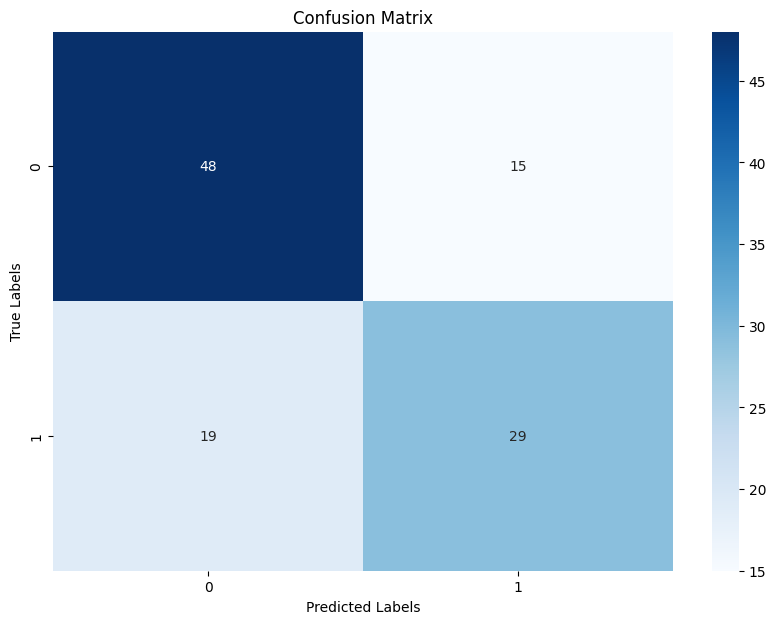

In [108]:
# Getting confusion matrix
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

true_labels = [item['labels'].item() for item in test_dataset]

cm = confusion_matrix(true_labels, predicted_labels)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [109]:
from huggingface_hub import notebook_login
notebook_login()
trainer.push_to_hub("/Eappelson/new")


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Eappelson/predicting_misdirection/commit/aa6efb3be3de512810a06dc35bc7942936601729', commit_message='/Eappelson/new', commit_description='', oid='aa6efb3be3de512810a06dc35bc7942936601729', pr_url=None, pr_revision=None, pr_num=None)